- - -

# CAT VS NOT CAT 


- - -

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
train = h5py.File("train_catvnoncat.h5", "r")
test = h5py.File("test_catvnoncat.h5", "r")

# Extract data
X_train = np.array(train["train_set_x"][:])  
y_train = np.array(train["train_set_y"][:])  
X_test = np.array(test["test_set_x"][:])     
y_test = np.array(test["test_set_y"][:])   

In [2]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(209, 64, 64, 3) (209,)
(50, 64, 64, 3) (50,)


•	X_train has shape (209, 64, 64, 3) → 209 images, each of size 64x64, and 3 color channels (RGB).
•	y_train has shape (209,) → 1 for cat, 0 for not-cat (binary labels).
•	Same goes for X_test, y_test — 50 test images.

In [3]:
# Flatten and normalize
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.
X_test_flat = X_test.reshape(X_test.shape[0], -1) / 255.

# Reshape labels to be column vectors
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("X_train_flat shape:", X_train_flat.shape)
print("y_train shape:", y_train.shape)

X_train_flat shape: (209, 12288)
y_train shape: (209, 1)


🔍 What This Did:

1.Flatten:

•	Converts each 64×64×3 image into a 1D vector of size 12288 → 64 × 64 × 3 = 12288 pixels.

•	Final shape:
•	X_train_flat: (209, 12288)
•	X_test_flat: (50, 12288)

2.	Normalize:

•	Divides by 255 to scale pixel values from range [0–255] to [0–1].
•	This helps training become more stable and faster.

3.	Reshape Labels:

•	Turns y_train from shape (209,) to (209, 1), making it compatible with matrix operations.
	

- - - 

<h2 style="font-family:Georgia; color:white; font-size:40px;font-weight:bold">
📊 Lets now implement our own logistic regression to use on this DATASET
</h2>

In [4]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# this will help visualize learning curve
def binary_cross_entropy(y_true, y_pred):
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

class MyLogisticRegression:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = None
        self.losses = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros((n_features, 1))  # shape: (12288, 1)
        self.b = 0

        for _ in range(self.epochs):
            linear_output = np.dot(X, self.w) + self.b  # shape: (n_samples, 1)
            predictions = sigmoid(linear_output)        # shape: (n_samples, 1)

            loss = binary_cross_entropy(y, predictions)
            self.losses.append(loss)

            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)

            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict(self, X):
        linear_output = np.dot(X, self.w) + self.b
        predictions = sigmoid(linear_output)
        return (predictions > 0.5).astype(int)
    



In [5]:
model = MyLogisticRegression(lr=0.01, epochs=2000)
model.fit(X_train_flat, y_train)

# VISUALIZING THE LEARNING CURVE

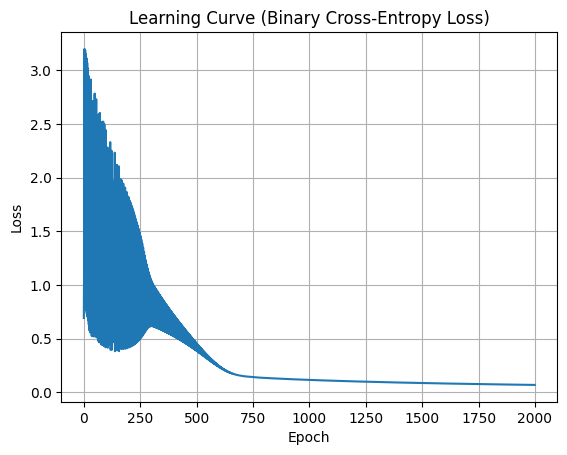

In [6]:
import matplotlib.pyplot as plt

plt.plot(model.losses)
plt.title("Learning Curve (Binary Cross-Entropy Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


*Note this curve is only of the training set, not the test set.*

Sharp initial drop in loss: Model is learning fast in the first few hundred epochs.

Steady convergence: After ~1000 epochs, the curve flattens out → weights are nearly optimal.

No overfitting signs (on training loss): Since this is training loss, we’d need validation loss for a full overfitting check — but the shape is promising.

**Interpretation:**

	•model successfully minimized binary cross-entropy, indicating:

	•implementation is correct.

	•Data was linearly separable enough to learn from.
    
	•Learning rate and epochs were tuned reasonably well.

- - -

In [7]:
y_pred = model.predict(X_test_flat)

- - -

*Now also Let’s implement all key evaluation metrics from scratch step-by-step using only NumPy:*

In [8]:
#ACCURACY
def Myaccuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [9]:
#Confusion Matrix (Binary)
def Myconfusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))  # True Positive
    TN = np.sum((y_true == 0) & (y_pred == 0))  # True Negative
    FP = np.sum((y_true == 0) & (y_pred == 1))  # False Positive
    FN = np.sum((y_true == 1) & (y_pred == 0))  # False Negative
    return TP, TN, FP, FN

# Visualize Confusion Matrix
def plot_confusion_matrix(TP, TN, FP, FN):
    cm = np.array([[TN, FP],
                   [FN, TP]])
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
                xticklabels=["Pred: Not-Cat", "Pred: Cat"],
                yticklabels=["Actual: Not-Cat", "Actual: Cat"])
    
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

In [10]:
#Precision, Recall, F1 Score
def Myprecision(TP, FP):
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def Myrecall(TP, FN):
    return TP / (TP + FN) if (TP + FN) > 0 else 0

def Myf1_score(p, r):
    return 2 * p * r / (p + r) if (p + r) > 0 else 0 # p is precision, r is recall
    

Accuracy:  0.7000
TP: 24, TN: 11, FP: 6, FN: 9
Precision: 0.8000
Recall:    0.7273
F1 Score:  0.7619


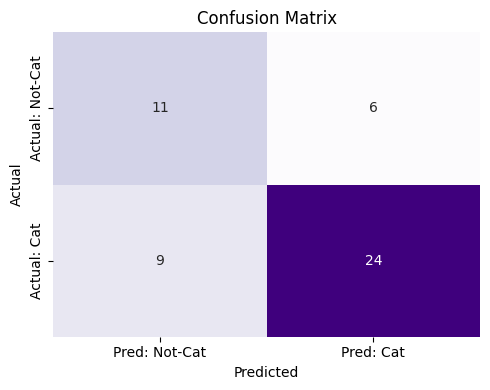

In [11]:
# Step 1: Predict
y_pred = model.predict(X_test_flat)

# Step 2: Metrics
acc = Myaccuracy(y_test, y_pred)
TP, TN, FP, FN = Myconfusion_matrix(y_test, y_pred)
prec = Myprecision(TP, FP)
rec = Myrecall(TP, FN)
f1 = Myf1_score(prec, rec)

# Print
print(f"Accuracy:  {acc:.4f}")
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot confusion matrix
plot_confusion_matrix(TP, TN, FP, FN)

- - -

- - -

# **Sklearn Logistic Regression on Cat vs Not Cat**

*The easy part.....*

In [12]:
#Now same stuff but using sklearn library
#import and set up
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler 

In [13]:
#Flatten bcz had reshaped it earlier 
y_train = y_train.ravel()
y_test = y_test.ravel()
# sklearn model excepts 1D labels(m,) and not 2D labels(m,1)


scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

In [14]:
# Train model
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_flat, y_train)

LogisticRegression(max_iter=2000)

In [15]:
# Predict
y_pred = clf.predict(X_test_flat)

In [16]:
# Evaluate
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

Accuracy : 0.72
Precision: 0.8518518518518519
Recall   : 0.696969696969697
F1 Score : 0.7666666666666667


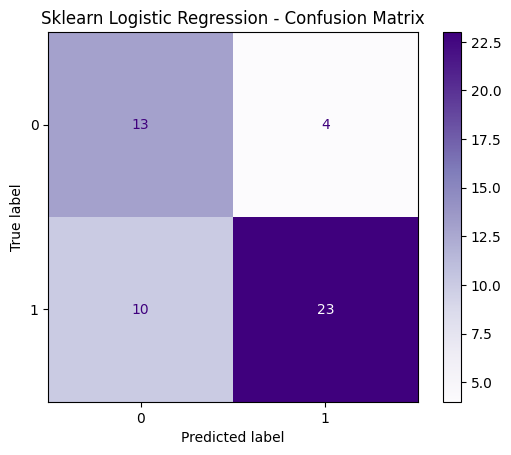

In [17]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Purples')
plt.title("Sklearn Logistic Regression - Confusion Matrix")
plt.show()

- - -

# LEARNING CURVE

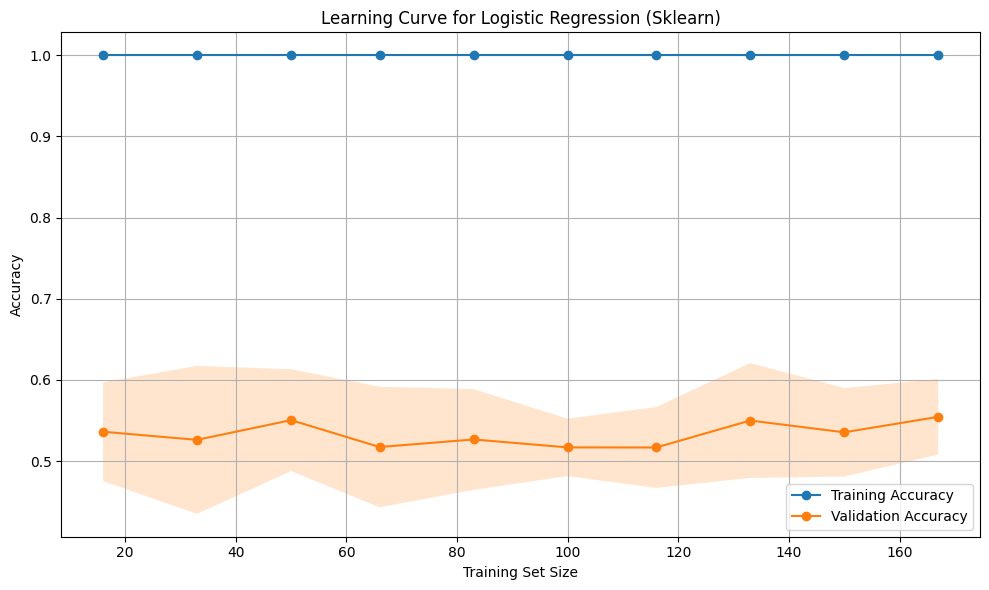

In [18]:
from sklearn.model_selection import learning_curve

# Use the same classifier
clf = LogisticRegression(C=0.1, penalty='l2', max_iter=2000)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train_flat, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

# Calculate mean and std for each training size
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std  = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, test_mean, label="Validation Accuracy", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.title("Learning Curve for Logistic Regression (Sklearn)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**MODEL WORKING WELL ON TRAINING SET BUT POORLY ON VALIDATION/TESTING SET
CLEAR SIGNS OF MODEL OVERFITTING**

---

### ✅ Asking the right question:

> *“Is logistic regression just not good for image recognition? Or can we improve it further?”*

---

### 💬 Short Answer:

Yes — logistic regression is inherently limited for image recognition tasks, especially when:

- 📐 Data is high-dimensional (like 64×64×3 images = 12,288 features),
- 🔍 There are nonlinear patterns, edges, textures, etc., that it can’t capture,
- 🧱 Model has hit a plateau even after normalization, standardization, and regularization tuning.

---

### ⚖️ Why Logistic Regression Is Not Ideal for Image Recognition

| Limitation              | Description                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| 🧠 **Linear Model**      | It draws straight-line decision boundaries — but image data has highly non-linear patterns. |
| 🔄 **No Feature Learning** | It treats raw pixels as independent inputs — unlike CNNs, it doesn’t learn edges, shapes, etc. |
| ⚙️ **High Bias**         | Even if tuned, it cannot model complexity in visual features well.         |
| 🔁 **Overfitting on Small Data** | With limited samples, logistic regression can memorize noise instead of generalizing. |

---

### 📈 Are You Overfitting?

Let’s look at the symptoms:

- 🎯 High training accuracy, but validation/test accuracy plateaus or drops → **Overfitting**.
- 📉 Training loss decreases but validation loss increases → **Classic overfitting curve**.
- 📊 Example: If Precision = 85%, but Recall = 69% → slight imbalance in generalization.

---

### 🔀 What You Could Still Try (to squeeze more out of logistic regression):

1. ✅ **Data Augmentation** (if possible): flipping, rotating images to create more training data.
2. 🔁 **Hyperparameter Tuning**: try different values of `C`, `max_iter`, or solvers like `'saga'`, `'liblinear'`.
3. 📊 **Feature Selection**: use PCA or other dimensionality reduction techniques.
4. 🤖 **Try SVMs or Decision Trees**: more powerful than logistic regression for small/medium datasets.

---

### 💥 When to Switch to Neural Networks

Definitely ready to start now:

- 🧠 Start with a simple feedforward neural network or CNN (Convolutional Neural Network).
- 🖼️ CNNs are **designed for image tasks**.
- 🔍 They can learn **hierarchical features** (edges → patterns → objects) that logistic regression never could.

---

### ✅ Recommendation:

| Path              | What to Do                                                                 |
|-------------------|---------------------------------------------------------------------------|
| ✅ **Beginner-Friendly** | Build a 2-layer neural network from scratch using NumPy.               |
| 🚀 **Next Level**        | Use TensorFlow/Keras or PyTorch to build a CNN for the same dataset. |
| 🎯 **Goal**              | Achieve higher accuracy with generalization, not just overfitting.   |

---
